# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import (
    NSGA2Generator,
    PolynomialMutation,
    SimulatedBinaryCrossover,
)
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator, VOCS

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",  # Format for log messages
    datefmt="%Y-%m-%d %H:%M:%S",  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(
        pm=1 / 30, eta_m=20
    ),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(
        delta_1=0.5, delta_2=0.5, eta_c=20
    ),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-05-10 00:55:06 - xopt.generator - INFO - Initialized generator nsga2
2025-05-10 00:55:06 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-05-10 00:55:06 - xopt.base - INFO - Running Xopt step
2025-05-10 00:55:06 - xopt.generators.ga.nsga2.NSGA2Generator.140191142235184 - INFO - generated 50 candidates in 2.38ms (removed 0 duplicate individuals)
2025-05-10 00:55:06 - xopt.generators.ga.nsga2.NSGA2Generator.140191142235184 - INFO - adding 50 new evaluated individuals to generator
2025-05-10 00:55:06 - xopt.generators.ga.nsga2.NSGA2Generator.140191142235184 - INFO - completed generation 1 in 0.018s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-05-10 00:55:06 - xopt.base - INFO - Running Xopt step
2025-05-10 00:55:06 - xopt.generators.ga.nsga2.NSGA2Generator.140191142235184 - INFO - generated 50 candidates in 8.96ms (removed 0 duplicate individuals)
2025-05-10 00:55:06 - xopt.generators.ga.nsga2.NSGA2Generator.140191142235184 - INFO - adding 50 new evaluated individuals to generator
2025-05-10 00:55:06 - xopt.generators.ga.nsga2.NSGA2Generator.1401911422

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: user 810 ms, sys: 8.03 ms, total: 818 ms
Wall time: 817 ms


In [7]:
# Inspect generator properties
print(
    f"Saw {generator.fevals} function evaluations"
)  # Number of function evaluations returned to generator
print(
    f"Completed {generator.n_generations} generations"
)  # Number of generations finished
print(
    f"Generated {generator.n_candidates} candidate solutions"
)  # Number of individuals generated

Saw 0 function evaluations
Completed 0 generations
Generated 0 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a
# unique index for indviduals.
#
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
X.generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.052247,0.593580,0.902160,0.636782,0.264124,0.470858,0.306823,0.522612,0.402675,0.112571,...,0.898519,0.405546,0.513913,0,4,0.052247,4.674816,5.250701,0.000030,False
1,0.101335,0.836313,0.292675,0.229714,0.289060,0.828366,0.056066,0.617582,0.418446,0.752678,...,0.865630,0.840338,0.272793,0,46,0.101335,5.168172,5.939748,0.000011,False
2,0.108308,0.760261,0.849372,0.126657,0.565642,0.684411,0.280642,0.001554,0.798483,0.513070,...,0.166172,0.668352,0.310949,0,25,0.108308,4.559309,5.288163,0.000008,False
3,0.113195,0.792715,0.005148,0.400103,0.337500,0.407688,0.036658,0.490689,0.791489,0.228838,...,0.957507,0.283405,0.637772,0,37,0.113195,4.815178,5.563136,0.000007,False
4,0.125633,0.189605,0.140702,0.911935,0.832705,0.742741,0.092909,0.502089,0.376493,0.680706,...,0.671431,0.822494,0.147852,0,17,0.125633,4.106205,4.791487,0.000007,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(X.generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
X.generator.data[
    X.generator.data["xopt_candidate_idx"].isin(X.generator.history_idx[0])
].head()

[2469, 2435, 2278, 2453, 2441, 2434, 2310, 2328, 2397, 2277, 2484, 2246, 2415, 2317, 2359, 2342]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.052247,0.593580,0.902160,0.636782,0.264124,0.470858,0.306823,0.522612,0.402675,0.112571,...,0.898519,0.405546,0.513913,0,4,0.052247,4.674816,5.250701,0.000030,False
1,0.101335,0.836313,0.292675,0.229714,0.289060,0.828366,0.056066,0.617582,0.418446,0.752678,...,0.865630,0.840338,0.272793,0,46,0.101335,5.168172,5.939748,0.000011,False
2,0.108308,0.760261,0.849372,0.126657,0.565642,0.684411,0.280642,0.001554,0.798483,0.513070,...,0.166172,0.668352,0.310949,0,25,0.108308,4.559309,5.288163,0.000008,False
3,0.113195,0.792715,0.005148,0.400103,0.337500,0.407688,0.036658,0.490689,0.791489,0.228838,...,0.957507,0.283405,0.637772,0,37,0.113195,4.815178,5.563136,0.000007,False
4,0.125633,0.189605,0.140702,0.911935,0.832705,0.742741,0.092909,0.502089,0.376493,0.680706,...,0.671431,0.822494,0.147852,0,17,0.125633,4.106205,4.791487,0.000007,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

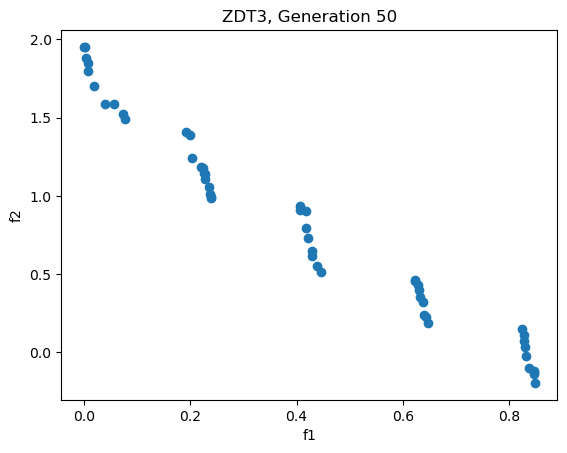

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = X.generator.data[
    X.generator.data["xopt_candidate_idx"].isin(X.generator.history_idx[-1])
]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {X.generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory
 - `log.txt`: Log output from the generator is recorded to this file

 Wile running each of the blocks, go ahead and open the temporary directory printed from the next cell and take a look at the files for yourself.

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f'Will write data to "{output_dir}"')

Will write data to "/tmp/tmpfmf6qhdk"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # Turn on checkpoints and set how often (in terms of generations) we save the optimizer state
    log_level=logging.DEBUG,  # Set the level of log messages output to our log file
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f'"{output_dir}": {os.listdir(output_dir)}')
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f'"checkpoints": {os.listdir(checkpoint_dir)}')

"/tmp/tmpfmf6qhdk": ['checkpoints', 'data.csv', 'log.txt', 'vocs.txt', 'populations.csv']
"checkpoints": ['20250510_005508_3.txt', '20250510_005509_1.txt', '20250510_005508_1.txt', '20250510_005508_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(
    generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir),
    evaluator=ev,
    vocs=prob_vocs,
)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f'Requested path: "{output_dir}"')
print(f'Path used:      "{X.generator.output_dir}"')

# Clean up the directory
X.generator.close_log_file()

Requested path: "/tmp/tmpfmf6qhdk"
Path used:      "/tmp/tmpfmf6qhdk_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(X.generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.020245,0.135555,0.174769,0.536714,0.854987,0.469211,0.173056,0.007371,0.677162,0.753783,...,0.393806,0.233005,0.881542,0,15,0.020245,5.064260,5.407146,0.000071,False
1,0.025359,0.191694,0.503379,0.047568,0.806949,0.104945,0.237305,0.681710,0.401237,0.017906,...,0.180295,0.834229,0.687923,0,11,0.025359,4.836452,5.218361,0.000010,False
2,0.043000,0.193169,0.695313,0.387191,0.476477,0.066313,0.776525,0.399450,0.853078,0.814449,...,0.522846,0.129857,0.230031,0,9,0.043000,5.161981,5.698978,0.000008,False
3,0.115179,0.978176,0.136124,0.281753,0.477872,0.232655,0.992201,0.412185,0.871513,0.097109,...,0.576415,0.502860,0.233657,0,35,0.115179,4.879253,5.631783,0.000010,False
4,0.146635,0.002652,0.742362,0.482714,0.802738,0.110126,0.940240,0.942637,0.173308,0.617431,...,0.793627,0.141211,0.001101,0,49,0.146635,4.524919,5.257097,0.000012,False


In [16]:
# Read the VOCS object back in. This can be used for data analysis / restarting optimizations
with open(os.path.join(X.generator.output_dir, "vocs.txt")) as f:
    vocs_from_file = VOCS.from_dict(json.load(f))

# Show the objectives
vocs_from_file.objectives

{'f1': 'MINIMIZE', 'f2': 'MINIMIZE'}

In [17]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(X.generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.230025,0.030308,0.107701,0.164067,0.089896,0.000404,0.017186,0.004498,0.174147,0.301241,...,0.067859,0.001424,31,1589,0.230025,1.170873,2.042516,0.000010,False,32
1551,0.228116,0.038260,0.107701,0.164070,0.020372,0.008461,0.017186,0.004498,0.174147,0.301705,...,0.067859,0.000713,29,1497,0.228116,1.173500,2.030352,0.000006,False,32
1552,0.828085,0.040101,0.108107,0.163991,0.013599,0.007714,0.008501,0.020067,0.088470,0.320987,...,0.102981,0.000219,29,1487,0.828085,0.100256,2.039189,0.000006,False,32
1553,0.433763,0.037412,0.108022,0.142994,0.139819,0.007470,0.000705,0.100063,0.176634,0.354304,...,0.061771,0.001080,30,1527,0.433763,0.778827,2.115237,0.000006,False,32
1554,0.238229,0.030321,0.107027,0.164295,0.017791,0.008349,0.017900,0.018706,0.159070,0.345339,...,0.093657,0.000105,28,1418,0.238229,1.109967,2.026993,0.000006,False,32


In [18]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

# Clean up the output
X.generator.close_log_file()
shutil.rmtree(X.generator.output_dir)

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=16, fevals=800)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=16, fevals=800)


In [19]:
# Clean up the original output
X.generator.close_log_file()

In [20]:
shutil.rmtree(output_dir)